# Alberta Covid19 data model
This notebook constructs the cumulative new patients stats from the Alberta Health data, fits a logistic function to the data, and predicts when the pandemic spread curve is flattened to less than one new patient per day. 
Note: Easing social distancing measures may reintriduce a secondary logistic curve.

In [3]:
#https://covid19stats.alberta.ca/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit#,root,fsolve
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error as mse
%matplotlib inline

### Download the data, do basic cleaning and set the starting date to March 1.

In [4]:
#download data manually... the link doesn't work
df=pd.read_csv(r"C:\Users\ehsan\Downloads\covid19dataexport.csv",index_col=0)
df["Date reported"]=pd.to_datetime(df['Date reported'])
basedate=pd.Timestamp("2020-03-1")
df['time since']=(df['Date reported']-basedate).dt.days
#df = df[df['Case status'] == 'Active']
df

,Date reported,Alberta Health Services Zone,Gender,Age group,Case status,Case type,time since
1,2020-04-21,Calgary Zone,Male,Unknown,Active,Confirmed,51
2,2020-04-23,Calgary Zone,Female,40-49 years,Active,Confirmed,53
3,2020-04-21,Calgary Zone,Male,80+ years,Active,Confirmed,51
4,2020-04-29,South Zone,Male,40-49 years,Active,Confirmed,59
5,2020-04-27,Calgary Zone,Male,50-59 years,Active,Confirmed,57
...,...,...,...,...,...,...,...
5666,2020-05-01,Calgary Zone,Male,50-59 years,Active,Probable,61
5667,2020-05-01,South Zone,Female,20-29 years,Active,Probable,61
5668,2020-03-22,Calgary Zone,Male,20-29 years,Recovered,Probable,21
5669,2020-03-26,Calgary Zone,Female,30-39 years,Recovered,Probable,25


### Create exploratory pivot tables.

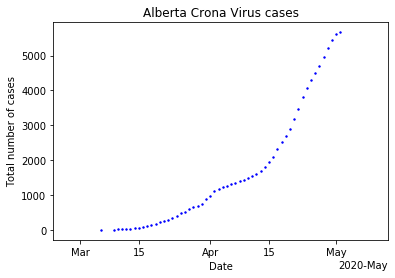

In [5]:
table1=pd.pivot_table(df,values='Age group',index=['Date reported','time since'],aggfunc=np.size)
table1['cumsum']=table1['Age group'].cumsum()
table1.reset_index(inplace=True)
table1.drop('Age group',axis=1,inplace=True)


x=table1['Date reported']
y=table1['cumsum']
table1

fig,ax=plt.subplots(nrows=1, ncols=1)
ax.scatter(x,y,s=2,c='b')
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.ylabel('Total number of cases')
plt.xlabel('Date')
plt.title('Alberta Crona Virus cases')
plt.show()

### Fit a logistic function to the curve

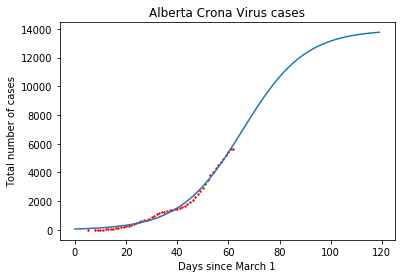

In [6]:
def myfunc(x,a,b,c):
    r=c/(1+np.exp(-(x-b)/a))
    return(r)

#xx=np.arange(90)
#a=9.87
#b=44.7
#c=4240
#yy=myfunc(xx,a,b,c)
x=table1['time since']
fit=curve_fit(myfunc,x,y,p0=[20,40,2500])
a,b,c=fit[0]
c=int(c)-1
ndays=120

xx=np.arange(ndays)
yy=myfunc(xx,a,b,c)

xx=np.arange(ndays)
yy=myfunc(xx,a,b,c)

fig,ax=plt.subplots(nrows=1, ncols=1)
ax.scatter(table1['time since'],table1['cumsum'],s=2,c='r')
ax.plot(xx,yy)
plt.ylabel('Total number of cases')
plt.xlabel('Days since March 1')
plt.title('Alberta Crona Virus cases')
plt.show()

y_pred=myfunc(x,a,b,c)
err=np.sqrt(mse(y,y_pred))



## Determine when the curve is flattened enough to have less than one new patient per day

The pandemic spread curve will be flattened to less than one new patient per day in 119 days, or on June 28 2020


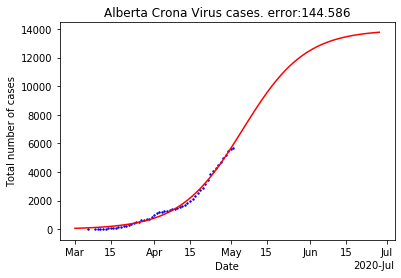

In [7]:
for sol in range(ndays):
    r=int(c)-myfunc(sol,a,b,c)
    if r<1:
        break
        
endday=basedate+pd.DateOffset(days=sol)

print('The pandemic spread curve will be flattened to less than one new patient per day in '+str(sol)+' days, or on '+endday.strftime("%B %d %Y"))

r=[]
for i in range(ndays):
    r.append(basedate+pd.DateOffset(days=i))

a_r=np.array([r,yy]).T
df_pred=pd.DataFrame(a_r,columns=['Date reported','prediction'])


df_total=pd.merge(df_pred,table1,on='Date reported',how='left')


fig,ax=plt.subplots(1)
ax.plot(df_total['Date reported'],df_total['prediction'],c='r')
ax.scatter(df_total['Date reported'],df_total['cumsum'],s=2,c='b')
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.ylabel('Total number of cases')
plt.xlabel('Date')
plt.title('Alberta Crona Virus cases. error:'+str(np.round(err,3)))
plt.show()

